In [2]:
import os 
import yaml
from omegaconf import OmegaConf

def find_config_files(root_dir):
    for file in os.listdir(root_dir):
        file_path = os.path.join(root_dir, file)
        if file == 'config.yaml':
            yield file_path
        elif os.path.isdir(file_path) and not file.startswith('.'):
            for config_file in find_config_files(file_path):
                yield config_file

def get_config_value(config, key):
    if '.' in key:
        key_parts = key.split('.')
        subconfig = config
        for part in key_parts:
            if part in subconfig:
                subconfig = subconfig[part]
            else:
                return None
        return subconfig
    else:
        return config.get(key)

configs = {}
for file_path in find_config_files('../logs/'):
    with open(file_path, 'r') as f:
        data = yaml.safe_load(f)
        # Do something with the data
        configs[os.path.dirname(file_path)] = OmegaConf.create(data)


In [3]:
print(get_config_value(configs['../logs/hydra/2023_04_30_16_59_28'], 'preprocess.smooth'))
print(get_config_value(configs['../logs/hydra/2023_03_30_16_59_28'], 'model.type'))

print(os.getcwd())
print(type(configs), len(configs))

d = configs['../logs/hydra/2023_03_30_17_57_06/9']
print(type(d))
print(OmegaConf.to_yaml(d))

KeyError: '../logs/hydra/2023_03_30_16_59_28'

In [128]:
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_loss_vs_parameter(param_names):
    # Assuming you have loaded the config.yaml files into a dictionary named 'configs'
    param_values = {}
    for param_name in param_names:
        param_values[param_name] = set(get_config_value(config, param_name) for config in configs.values())

    # Compute trailing averages for each combination of parameter values
    trailing_averages = {}
    for param_values_combination in itertools.product(*param_values.values()):
        matching_configs = {}
        for config_path, config in configs.items():
            if all(get_config_value(config, param_name) == param_value for param_name, param_value in zip(param_names, param_values_combination)):
                matching_configs[config_path] = config

        if not matching_configs:
            continue

        trailing_avg_values = []
        for config_path, _ in matching_configs.items():
            loss_path = os.path.join(config_path, 'loss_curves.csv')
            if os.path.exists(loss_path):
                loss_df = pd.read_csv(loss_path)
                num_worms = len(os.listdir(config_path)) - 3 # Subtract 3 for .hydra, config.yaml, and loss_curves.csv
                trailing_avg = loss_df['centered_test_losses'][-num_worms:].mean()
                trailing_avg_values.append(trailing_avg)

        param_values_tuple = tuple(param_values_combination)
        trailing_averages[param_values_tuple] = sum(trailing_avg_values) / len(trailing_avg_values)

    # Plot trailing averages as scatter plot with regression line and confidence intervals
    plt.figure()
    plt.xlabel(', '.join(param_names))
    plt.ylabel('Mean Trailing Avg. Validation Loss')
    plt.title('Mean Trailing Avg. Validation Loss vs. {}'.format(', '.join(param_names)))
    param_values_tuples = list(trailing_averages.keys())
    param_values_lists = [list(t) for t in param_values_tuples]
    sns.regplot(x=param_values_lists, y=list(trailing_averages.values()), scatter=True, ci=95, order=2, label='Data')
    plt.legend()
    plt.show()


/Users/quileesimeon/opt/anaconda3/envs/worm-graph/lib/python3.9/site-packages/seaborn/algorithms.py:98: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))


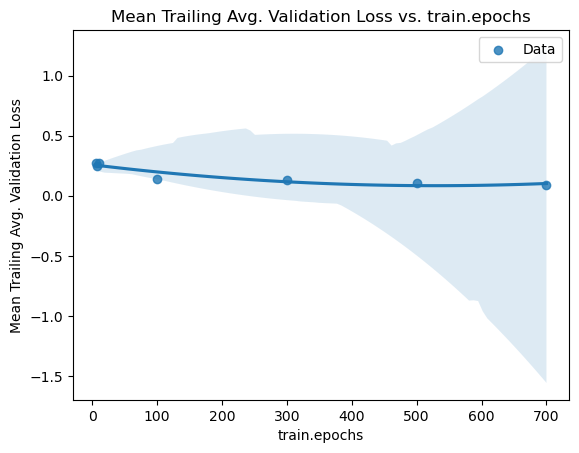

In [125]:
plot_loss_vs_parameter(['train.epochs'])